In [66]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from scipy.stats import spearmanr
import statsmodels.api as sm

In [67]:
snp500_ticker = yf.Ticker("^GSPC")
snp_price = snp500_ticker.history(start='1998-10-12', end='2023-09-30', auto_adjust=True)

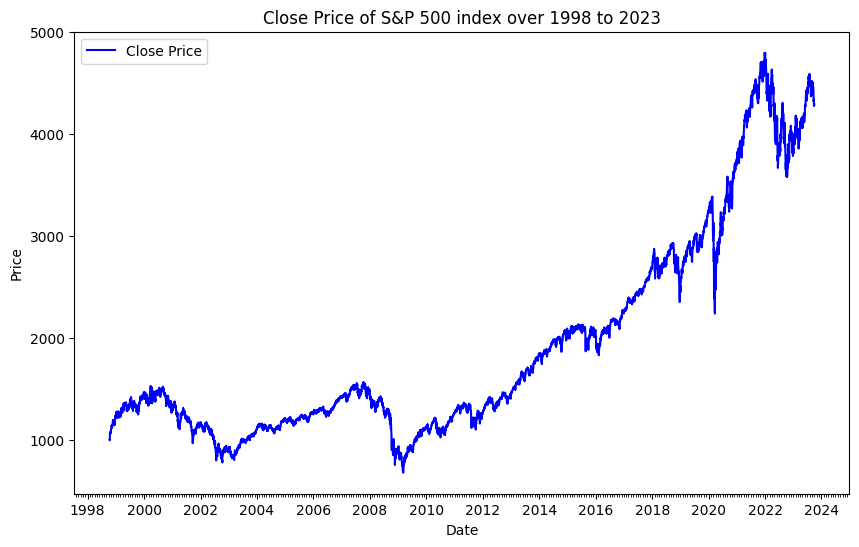

In [68]:
snp_price.index = pd.to_datetime(snp_price.index)
plt.figure(figsize=(10, 6))
plt.plot(snp_price['Close'].index, snp_price['Close'], label='Close Price', color='blue')

# Adding title and labels
plt.title('Close Price of S&P 500 index over 1998 to 2023')
plt.xlabel('Date')  # Assuming your index is date or replace it with an appropriate x-axis label
plt.ylabel('Price')

plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  # Major ticks every 2 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format ticks to display year
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator()) 

# plt.xticks(rotation=45)

# Show the legend
plt.legend()

# Display the plot
plt.show()


### Problem 3 (a)

Perform the nonparametric test of independence of the log returns on
S&P500 based on the Spearman rank correlation. What is your conclusion
about whether the EMH holds? Which form of the EMH have you tested
and under which RW assumption?


In [69]:
df = pd.DataFrame()
df['Close'] = snp_price['Close']
df['log_returns'] = np.log(df['Close'] / df['Close'].shift(1))
df = df.dropna()

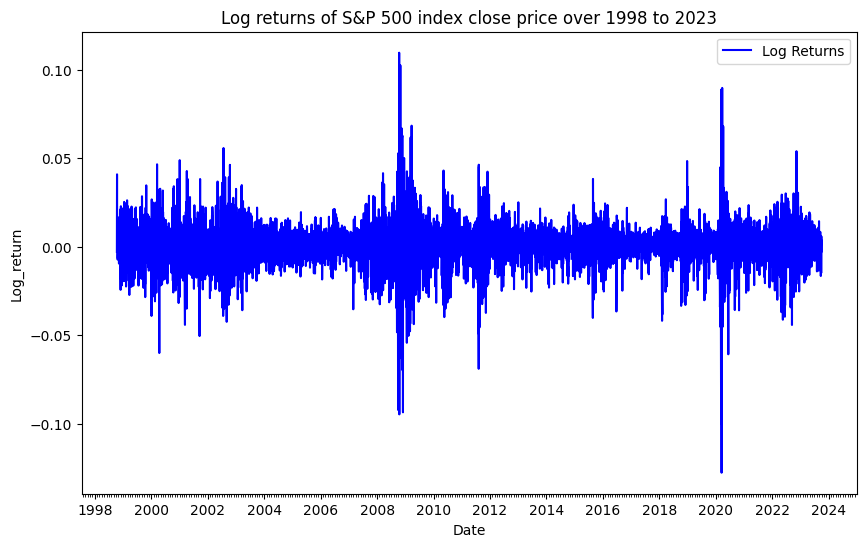

In [70]:
plt.figure(figsize=(10, 6))
plt.plot(df['log_returns'].index, df['log_returns'], label='Log Returns', color='blue')

# Adding title and labels
plt.title('Log returns of S&P 500 index close price over 1998 to 2023')
plt.xlabel('Date')  # Assuming your index is date or replace it with an appropriate x-axis label
plt.ylabel('Log_return')

plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  # Major ticks every 2 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format ticks to display year
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator()) 

# plt.xticks(rotation=45)

# Show the legend
plt.legend()

# Display the plot
plt.show()

In [71]:
n = len(df['log_returns'])
group_1 = []
group_2 = []

for x in range(n):
    if x % 2 != 0:
        group_1.append(df.iloc[x, 1])
        
    else:
        group_2.append(df.iloc[x, 1])

group_1.sort()
group_2.sort()

differentials = [x - y for (x, y) in zip(group_1, group_2)]
R = sum(differentials)

z_stat = (6*R - n*((n**2) - 1)) / (n * (n + 1) * np.sqrt(n - 1))
z_stat

corr, p_value = spearmanr(group_1, group_2)

print(f'Hand made z-stat: {z_stat}; scipy func p-val: {p_value}')
    

Hand made z-stat: -79.25276020561701; scipy func p-val: 0.0


As we can see we have strong evidence to reject the null about the absence of dependence in log returns. However this test leverages RW1 e_i ~ iid which is very restrictive and unrealistic assumption that is not holds in returns time series as returns exhibits heteroscedasticity.

Here we attempting to test weak form of EMH as we assess the dependence only with past prices themselves. If the conditions for test would hold then we would conclude that EMH does not hold, but as we use unrealistic assumption our results inconclusive.

### Problem 3 (b)

Estimate the regression of S&P 500 log returns on a constant, the previous
day return, the returns three and nine days ago

In [72]:
df['Lag_1'] = df['log_returns'].shift(1)  
df['Lag_3'] = df['log_returns'].shift(3)  
df['Lag_9'] = df['log_returns'].shift(9)  
df = df.dropna()

(i) Are the coefficients significant (rely on standard asymptotic approximation to answer this question)? What is your conclusion
about whether the EMH holds? Which form of the EMH have you
tested this way and under which RW assumption?

In [73]:
X = sm.add_constant(df[['Lag_1', 'Lag_3', 'Lag_9']])
y = df['log_returns']

model = sm.OLS(y, X)
#results = model.fit(cov_type='HAC', cov_kwds={'maxlags': int(0.75 * (n**(1/3)))})
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            log_returns   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     23.54
Date:                Mon, 21 Oct 2024   Prob (F-statistic):           3.82e-15
Time:                        13:42:46   Log-Likelihood:                 18690.
No. Observations:                6273   AIC:                        -3.737e+04
Df Residuals:                    6269   BIC:                        -3.734e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      1.498      0.1

Under standart asymptotic approximation we can see that Lag_1 and Lag_9 drings significant coefficients as well as confidence interval bounds does not alter their signs. If standart asymtotic approximation would be correct that would mean that weak form of EMH does not hold. We test it under assumption of e ~ iid Normal => RW_1

(ii)  Run a simple (residuals) bootstrap procedure for B = 2000 bootstrap samples. Report two bootstrapped confidence intervals (CI)
for all autoregressive coefficients: percentile bootstrap confidence
intervals and percentile-t bootstrap confidence intervals. Are the
coefficients significant?


In [74]:
original_residuals = results.resid
original_params = results.params

In [75]:
B = 2000  
bootstrap_coefs = np.zeros((B, X.shape[1])) 

for i in range(B):
    #resample the residuals with replacement
    boot_residuals = np.random.choice(original_residuals, size=len(original_residuals), replace=True)
    
    #create a new dependent variable by adding the resampled residuals to the original fitted values
    y_boot = results.fittedvalues + boot_residuals
    
    boot_model = sm.OLS(y_boot, X).fit()
    
    bootstrap_coefs[i, :] = boot_model.params
    

In [76]:
percentile_ci = np.percentile(bootstrap_coefs, [2.5, 97.5], axis=0)

for i, param_name in enumerate(results.params.index):
    print(f"Percentile CI for {param_name}: [{percentile_ci[0, i]:.4f}, {percentile_ci[1, i]:.4f}]")

Percentile CI for const: [-0.0001, 0.0005]
Percentile CI for Lag_1: [-0.1231, -0.0733]
Percentile CI for Lag_3: [-0.0189, 0.0314]
Percentile CI for Lag_9: [0.0110, 0.0601]


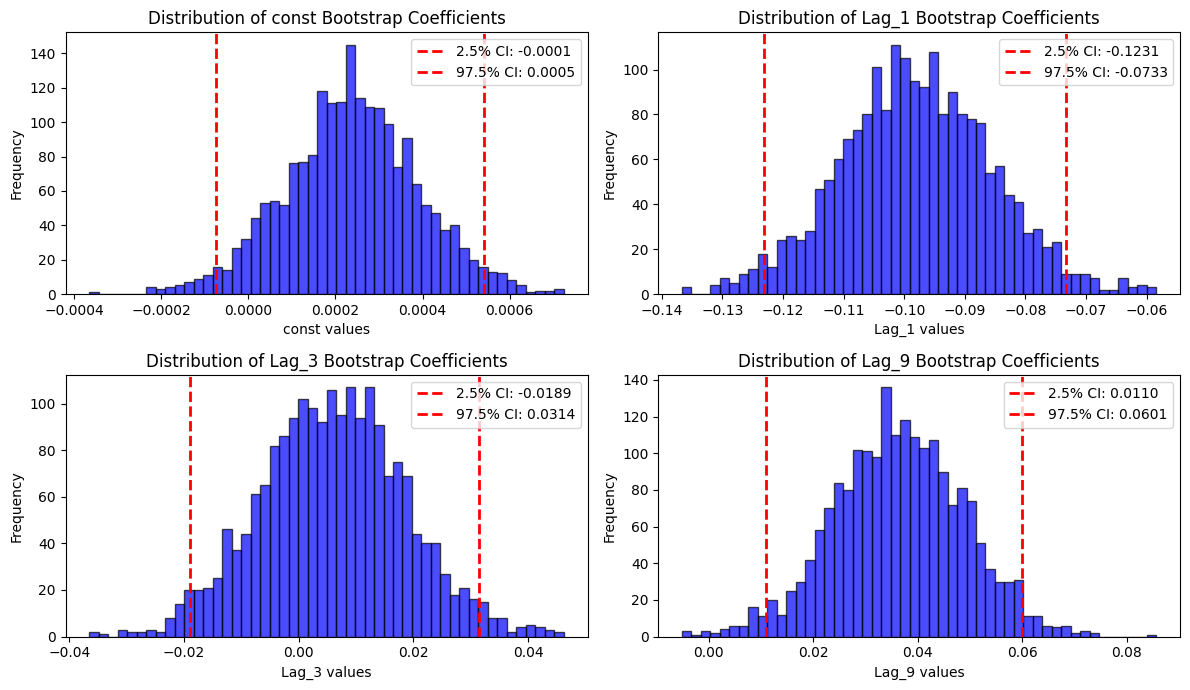

In [77]:
param_names = results.params.index
num_params = len(param_names)

fig, axes = plt.subplots(nrows=(num_params + 1) // 2, ncols=2, figsize=(12, (num_params // 2 + 1) * 4 - 5))

axes = axes.flatten()

for i, param_name in enumerate(param_names):
    axes[i].hist(bootstrap_coefs[:, i], bins=50, alpha=0.7, color='blue', edgecolor='black')

    axes[i].axvline(percentile_ci[0, i], color='red', linestyle='dashed', linewidth=2, label=f'2.5% CI: {percentile_ci[0, i]:.4f}')
    axes[i].axvline(percentile_ci[1, i], color='red', linestyle='dashed', linewidth=2, label=f'97.5% CI: {percentile_ci[1, i]:.4f}')
   
    axes[i].set_title(f'Distribution of {param_name} Bootstrap Coefficients')
    axes[i].set_xlabel(f'{param_name} values')
    axes[i].set_ylabel('Frequency')
    
    
    axes[i].legend()

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [78]:
bootstrap_se = np.std(bootstrap_coefs, axis=0)

t_statistics = (bootstrap_coefs - results.params.values) / bootstrap_se

t_percentiles = np.percentile(t_statistics, [2.5, 97.5], axis=0)

percentile_t_ci_lower = results.params.values - t_percentiles[1] * bootstrap_se
percentile_t_ci_upper = results.params.values - t_percentiles[0] * bootstrap_se

for i, param_name in enumerate(results.params.index):
    print(f"Percentile-t CI for {param_name}: [{percentile_t_ci_lower[i]:.4f}, {percentile_t_ci_upper[i]:.4f}]    Percentile CI for {param_name}: [{percentile_ci[0, i]:.4f}, {percentile_ci[1, i]:.4f}]")


Percentile-t CI for const: [-0.0001, 0.0005]    Percentile CI for const: [-0.0001, 0.0005]
Percentile-t CI for Lag_1: [-0.1223, -0.0725]    Percentile CI for Lag_1: [-0.1231, -0.0733]
Percentile-t CI for Lag_3: [-0.0197, 0.0305]    Percentile CI for Lag_3: [-0.0189, 0.0314]
Percentile-t CI for Lag_9: [0.0132, 0.0623]    Percentile CI for Lag_9: [0.0110, 0.0601]


Both percentile and t-percentile bootstraps gives very similar CIs (which confirms t-distribution approxinmation is appropriate). We can see that Lag_1 and Lag_9 seems to be significant as CI for them does not include 0. 

(iii) Run a bootstrap procedure with drawing blocks of length 18 for
 B =2000 bootstrap samples. Report two bootstrapped condence
 intervals (CI) for all autoregressive coe cients: percentile boot
strap condence intervals and percentile-t bootstrap condence in
tervals. Are the coe cients signi cant?

In [79]:
def block_bootstrap_ci(block_size, B=2000, overlap=False, plot=False):

    X = sm.add_constant(df[['Lag_1', 'Lag_3', 'Lag_9']])
    y = df['log_returns']

    model = sm.OLS(y, X).fit()

    original_coefs = model.params
    bootstrap_coefs = np.zeros((B, X.shape[1]))
    n = len(y)
    
    # Function to create block indices for non-overlapping or overlapping blocks
    def create_blocks(overlap):
        if overlap:
            block_starts = np.arange(n - block_size + 1)
        else:
            block_starts = np.arange(0, n, block_size)
        
        return block_starts

    # Function to resample data using block bootstrap
    def block_bootstrap(X, y, block_size, overlap):

        block_starts = create_blocks(overlap)
        sampled_indices = []

        while len(sampled_indices) < n:

            start_idx = np.random.choice(block_starts)
            end_idx = min(start_idx + block_size, n)

            sampled_indices.extend(np.arange(start_idx, end_idx))
        
        if len(sampled_indices) > n + block_size:
            print(f'Length of bootstrap sample are more than {len(block_size)} more than initial sample lenght! Current len: {len(sampled_indices)}')
        elif len(sampled_indices) < n - block_size:
            print(f'Length of bootstrap sample are more than {len(block_size)} less than initial sample lenght! Current len: {len(sampled_indices)}')
        
        sampled_indices = np.array(sampled_indices[:n])  # Ensure exact length
        return X[sampled_indices], y[sampled_indices]
    
    # Bootstrap procedure
    for i in range(B):
        X_boot, y_boot = block_bootstrap(X.values, y.values, block_size, overlap)
        
        boot_model = sm.OLS(y_boot, X_boot).fit()
        
        bootstrap_coefs[i, :] = boot_model.params

    percentile_ci = np.percentile(bootstrap_coefs, [2.5, 97.5], axis=0)


    bootstrap_se = np.std(bootstrap_coefs, axis=0)
    t_statistics = (bootstrap_coefs - original_coefs.values) / bootstrap_se
    t_percentiles = np.percentile(t_statistics, [2.5, 97.5], axis=0)

    percentile_t_ci_lower = original_coefs.values - t_percentiles[1] * bootstrap_se
    percentile_t_ci_upper = original_coefs.values - t_percentiles[0] * bootstrap_se

    percentile_ci_dict = {param_name: (percentile_ci[0, i], percentile_ci[1, i])
                          for i, param_name in enumerate(model.params.index)}
    percentile_t_ci_dict = {param_name: (percentile_t_ci_lower[i], percentile_t_ci_upper[i])
                            for i, param_name in enumerate(model.params.index)}
    
    if plot:
        param_names = model.params.index
        num_params = len(param_names)

        fig, axes = plt.subplots(nrows=(num_params + 1) // 2, ncols=2, figsize=(12, (num_params // 2 + 1) * 4 - 5))
        axes = axes.flatten()

        # Loop through each parameter and plot its bootstrap distribution and CIs
        for i, param_name in enumerate(param_names):
            axes[i].hist(bootstrap_coefs[:, i], bins=50, alpha=0.7, color='blue', edgecolor='black')

            axes[i].axvline(0, color='black', linestyle='-', linewidth=4)

            # Add percentile confidence intervals
            axes[i].axvline(percentile_ci[0, i], color='red', linestyle='dashed', linewidth=2, label=f'2.5% CI: {percentile_ci[0, i]:.4f}')
            axes[i].axvline(percentile_ci[1, i], color='red', linestyle='dashed', linewidth=2, label=f'97.5% CI: {percentile_ci[1, i]:.4f}')

            # Add percentile-t confidence intervals
            axes[i].axvline(percentile_t_ci_lower[i], color='green', linestyle='dashed', linewidth=2, label=f'Perc-t CI: {percentile_t_ci_lower[i]:.4f}')
            axes[i].axvline(percentile_t_ci_upper[i], color='green', linestyle='dashed', linewidth=2, label=f'Perc-t CI: {percentile_t_ci_upper[i]:.4f}')
            
            axes[i].set_title(f'Distribution of {param_name} Bootstrap Coefficients')
            axes[i].set_xlabel(f'{param_name} values')
            axes[i].set_ylabel('Frequency')
            
            axes[i].legend()

        
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()

        for param_name in percentile_ci_dict:
            print(f"Percentile CI for {param_name}: [{percentile_ci_dict[param_name][0]:.4f}, {percentile_ci_dict[param_name][1]:.4f}]    Percentile-t CI for {param_name}: [{percentile_t_ci_dict[param_name][0]:.4f}, {percentile_t_ci_dict[param_name][1]:.4f}]")

    return percentile_ci_dict, percentile_t_ci_dict


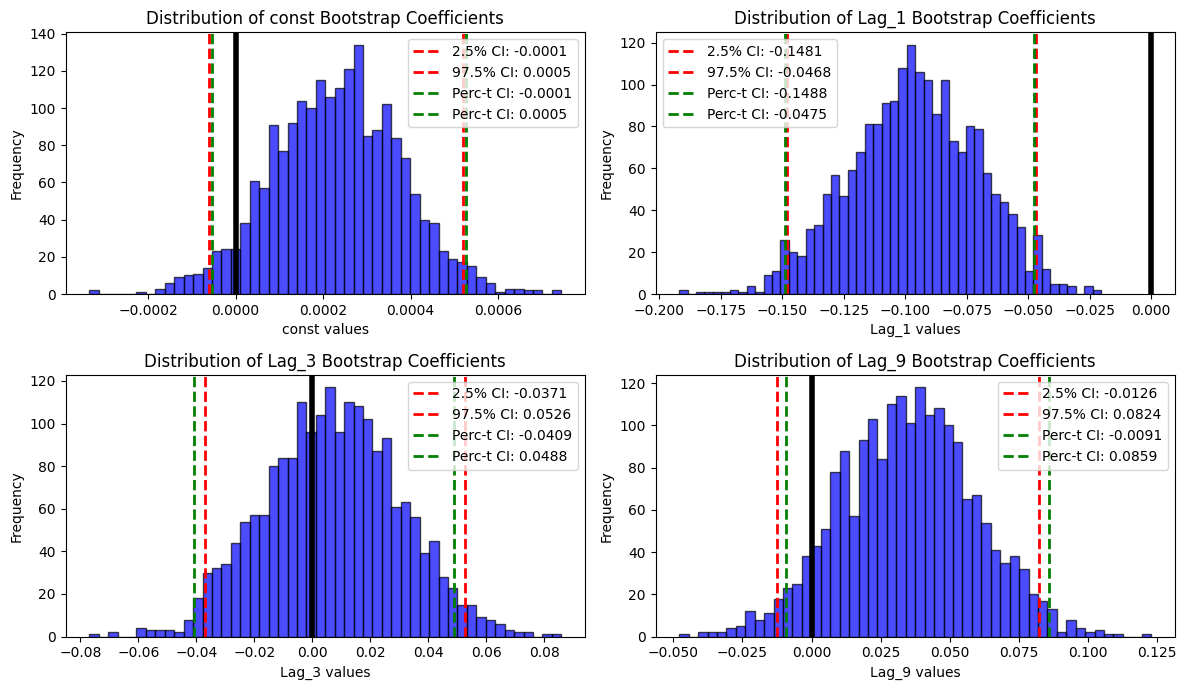

Percentile CI for const: [-0.0001, 0.0005]    Percentile-t CI for const: [-0.0001, 0.0005]
Percentile CI for Lag_1: [-0.1481, -0.0468]    Percentile-t CI for Lag_1: [-0.1488, -0.0475]
Percentile CI for Lag_3: [-0.0371, 0.0526]    Percentile-t CI for Lag_3: [-0.0409, 0.0488]
Percentile CI for Lag_9: [-0.0126, 0.0824]    Percentile-t CI for Lag_9: [-0.0091, 0.0859]


({'const': (-6.192595729039004e-05, 0.0005204245591757595),
  'Lag_1': (-0.14810848185457, -0.046827213955960276),
  'Lag_3': (-0.03711821685315713, 0.052557739614728656),
  'Lag_9': (-0.012643804862873484, 0.08239827401055119)},
 {'const': (-5.4964054898784016e-05, 0.0005273864615673655),
  'Lag_1': (-0.14879523614422868, -0.04751396824561892),
  'Lag_3': (-0.04089241264647821, 0.048783543821407586),
  'Lag_9': (-0.00914567043253324, 0.08589640844089146)})

In [80]:
block_bootstrap_ci(20, overlap=False, plot=True)

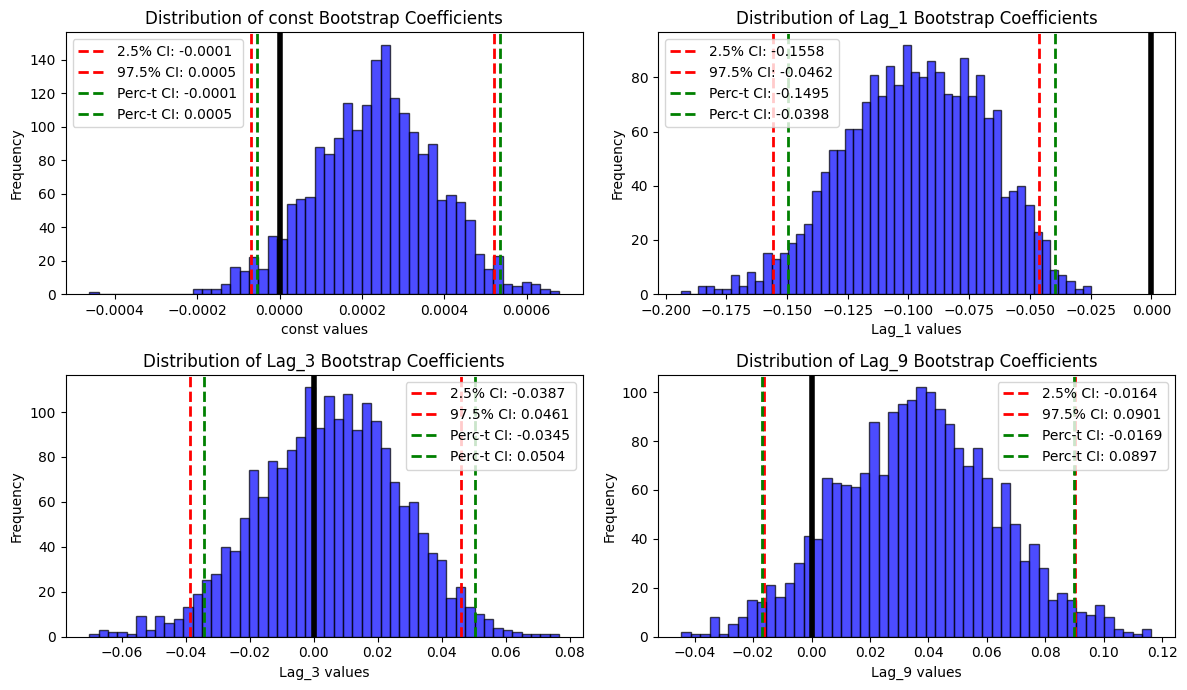

Percentile CI for const: [-0.0001, 0.0005]    Percentile-t CI for const: [-0.0001, 0.0005]
Percentile CI for Lag_1: [-0.1558, -0.0462]    Percentile-t CI for Lag_1: [-0.1495, -0.0398]
Percentile CI for Lag_3: [-0.0387, 0.0461]    Percentile-t CI for Lag_3: [-0.0345, 0.0504]
Percentile CI for Lag_9: [-0.0164, 0.0901]    Percentile-t CI for Lag_9: [-0.0169, 0.0897]


({'const': (-7.01524796574775e-05, 0.0005212173873287154),
  'Lag_1': (-0.15579122147010568, -0.046165901361169714),
  'Lag_3': (-0.038706886835029555, 0.046122268251759774),
  'Lag_9': (-0.016418334695206756, 0.09013871113528932)},
 {'const': (-5.57568830517399e-05, 0.000535612983934453),
  'Lag_1': (-0.14945654873901923, -0.03983122863008325),
  'Lag_3': (-0.03445694128350931, 0.050372213803280004),
  'Lag_9': (-0.016886107557271345, 0.08967093827322473)})

In [81]:
block_bootstrap_ci(20, overlap=True, plot=True)

Now in both cases with overlapping and non-overlapping blocks we recived only one significant coefficient - first lag (Lag_1) as only this CI does not include zero.

### Problem 4

In this exercise you will replicate some of the analysis from Goyal and Welch
 (2008). First, go to Amit Goyals webpage and download the le with updated
 data. You will use only the monthly data in this exercise.
 You will estimate various predictive models for equity premium of the S&P
 500, using the following 13 factors: 1) d/p, 2) d/y, 3) e/p, 4) d/e, 5) svar, 6)
 csp, 7) b/m, 8) ntis, 9) tbl, 10) ltr, 11) lty, 12) tms, 13) in . The de nition of
 these variables is provided in Chapter 1 of Goyal and Welch (2008). Some of
 these series is provided in the le you downloaded, others have to be computed
 using the raw data from the le and following the description from the paper.

### Problem 4 (a)

Use all the available periods (starting from 1937/05 for csp and from
 1926/12 for all the other models) to estimate 13 bivariate predictive
 regressions (i.e., include only a constant and the rst lag of one variable
 from the list above for each regression). For which models the coe cient
 on the predictor is signi cant? Report the point-estimate, t-stat, and R2
 for each model.

In [248]:
url = 'https://docs.google.com/spreadsheets/d/1bM7vCWd3WOt95Sf9qjLPZjoiafgF_8EG/export?format=csv&gid=407859737'
df = pd.read_csv(url)


In [249]:
print(df.columns)
print(df.index)
print(df.shape)
df = df.set_index('yyyymm')
df

Index(['yyyymm', 'Index', 'D12', 'E12', 'b/m', 'tbl', 'AAA', 'BAA', 'lty',
       'ntis', 'Rfree', 'infl', 'ltr', 'corpr', 'svar', 'csp', 'CRSP_SPvw',
       'CRSP_SPvwx'],
      dtype='object')
RangeIndex(start=0, stop=1836, step=1)
(1836, 18)


,Index,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,Rfree,infl,ltr,corpr,svar,csp,CRSP_SPvw,CRSP_SPvwx
yyyymm,,,,,,,,,,,,,,,,,
187101,4.44,0.2600,0.4000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187102,4.50,0.2600,0.4000,NaN,NaN,NaN,NaN,NaN,NaN,0.004967,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187103,4.61,0.2600,0.4000,NaN,NaN,NaN,NaN,NaN,NaN,0.004525,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187104,4.74,0.2600,0.4000,NaN,NaN,NaN,NaN,NaN,NaN,0.004252,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187105,4.86,0.2600,0.4000,NaN,NaN,NaN,NaN,NaN,NaN,0.004643,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202308,"4,507.66",69.1137,183.1700,0.210885,0.0530,0.0495,0.0602,0.0417,-0.016514,0.004500,0.004367,-0.0052,-0.0078,0.001337,NaN,-0.015424,-0.017192
202309,"4,288.05",69.3131,184.2500,0.218528,0.0532,0.0513,0.0616,0.0438,-0.017989,0.004300,0.002485,-0.0221,-0.0267,0.001023,NaN,-0.047566,-0.048621
202310,"4,193.80",69.6433,186.9767,0.221534,0.0534,0.0561,0.0663,0.0480,-0.014711,0.004700,-0.000383,-0.0121,-0.0187,0.001678,NaN,-0.021040,-0.022005


I will spesify additional variables as it stated in the paper:

d/p = ln(D12/SnP prices)

d/y = ln(D12_t/SnP prices_t-1)

e/p = ln(E12/Snp prices)

d/e = ln(D12/E12)

tms = lty - tbl

e_prim = CRSP_SPvw - Rfree

In [250]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1836 entries, 187101 to 202312
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Index       1836 non-null   object 
 1   D12         1836 non-null   float64
 2   E12         1836 non-null   float64
 3   b/m         1234 non-null   float64
 4   tbl         1248 non-null   float64
 5   AAA         1260 non-null   float64
 6   BAA         1260 non-null   float64
 7   lty         1260 non-null   float64
 8   ntis        1165 non-null   float64
 9   Rfree       1835 non-null   float64
 10  infl        1331 non-null   float64
 11  ltr         1176 non-null   float64
 12  corpr       1176 non-null   float64
 13  svar        1667 non-null   float64
 14  csp         788 non-null    float64
 15  CRSP_SPvw   1176 non-null   float64
 16  CRSP_SPvwx  1176 non-null   float64
dtypes: float64(16), object(1)
memory usage: 258.2+ KB


In [251]:
df['Index'] = df['Index'].replace({'[,]': ''}, regex=True).astype(float)

df['d/p'] = np.log(df['D12'] / df['Index'])
df['d/y'] = np.log(df['D12'] / df['Index'].shift(1))
df['e/p'] = np.log(df['E12'] / df['Index'])
df['d/e'] = np.log(df['D12'] / df['E12'])
df['tms'] = df['lty'] - df['tbl']
e_prim = df['CRSP_SPvw'] - df['Rfree']
print(df, e_prim)

          Index      D12       E12       b/m     tbl     AAA     BAA     lty  \
yyyymm                                                                         
187101     4.44   0.2600    0.4000       NaN     NaN     NaN     NaN     NaN   
187102     4.50   0.2600    0.4000       NaN     NaN     NaN     NaN     NaN   
187103     4.61   0.2600    0.4000       NaN     NaN     NaN     NaN     NaN   
187104     4.74   0.2600    0.4000       NaN     NaN     NaN     NaN     NaN   
187105     4.86   0.2600    0.4000       NaN     NaN     NaN     NaN     NaN   
...         ...      ...       ...       ...     ...     ...     ...     ...   
202308  4507.66  69.1137  183.1700  0.210885  0.0530  0.0495  0.0602  0.0417   
202309  4288.05  69.3131  184.2500  0.218528  0.0532  0.0513  0.0616  0.0438   
202310  4193.80  69.6433  186.9767  0.221534  0.0534  0.0561  0.0663  0.0480   
202311  4567.80  69.9735  189.7033  0.203676  0.0527  0.0528  0.0629  0.0450   
202312  4769.83  70.3037  192.4300  0.19

In [252]:
df = df.shift(1)
df['e_prim'] = e_prim

In [253]:
dependent_variables = ['d/p', 'd/y', 'e/p', 'd/e', 'svar', 'csp', 'b/m', 'ntis', 'tbl', 'ltr', 'lty', 'tms', 'infl']

for x in dependent_variables:
    y = df['e_prim']
     
    if x == 'csp':
        X = df.loc['193705':, x]
    else:
        X = df.loc['192612':, x]

    X = X.dropna()
    y = y.dropna()

    X, y = X.align(y, join='inner')

    X = sm.add_constant(X)
    
    #model = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={'maxlags': int(0.75 * (len(X)**(1/3)))})
    model = sm.OLS(y, X).fit(cov_type="HC0")
    #model = sm.OLS(y, X).fit()

    coefs = model.params
    t_stat = model.tvalues
    p_val = model.pvalues
    r_squared = model.rsquared

    if p_val.iloc[1] < 0.05:
        print(f'Parametr: {x} -> beta: {coefs.iloc[1]:.5f} | p-val: {p_val.iloc[1]:.5f}, t_stat: {t_stat.iloc[1]:.5f} | R^2 = {r_squared:.5f} | Significant variable', '\n')
    else:
        print(f'Parametr: {x} -> beta: {coefs.iloc[1]:.5f} | p-val: {p_val.iloc[1]:.5f}, t_stat: {t_stat.iloc[1]:.5f} | R^2 = {r_squared:.5f}', '\n')
    

Parametr: d/p -> beta: 0.00596 | p-val: 0.20833, t_stat: 1.25818 | R^2 = 0.00277 

Parametr: d/y -> beta: 0.00684 | p-val: 0.16108, t_stat: 1.40144 | R^2 = 0.00361 

Parametr: e/p -> beta: 0.00707 | p-val: 0.06842, t_stat: 1.82225 | R^2 = 0.00299 

Parametr: d/e -> beta: 0.00114 | p-val: 0.88715, t_stat: 0.14191 | R^2 = 0.00005 

Parametr: svar -> beta: 0.12498 | p-val: 0.85185, t_stat: 0.18676 | R^2 = 0.00019 

Parametr: csp -> beta: 2.10207 | p-val: 0.00795, t_stat: 2.65415 | R^2 = 0.01154 | Significant variable 

Parametr: b/m -> beta: 0.01556 | p-val: 0.17043, t_stat: 1.37082 | R^2 = 0.00594 

Parametr: ntis -> beta: -0.14272 | p-val: 0.09374, t_stat: -1.67597 | R^2 = 0.00460 

Parametr: tbl -> beta: -0.09984 | p-val: 0.05513, t_stat: -1.91786 | R^2 = 0.00315 

Parametr: ltr -> beta: 0.09956 | p-val: 0.14400, t_stat: 1.46107 | R^2 = 0.00204 

Parametr: lty -> beta: -0.08646 | p-val: 0.10207, t_stat: -1.63492 | R^2 = 0.00198 

Parametr: tms -> beta: 0.14729 | p-val: 0.20922, t_stat:

Note that the significants of the models are sencetive for model specification, for non-robust SE we have four significant variables, for White's SE only one and for HAC 2. Intrestingly that White's estimator creates wider SE than HAC. The only regressor that remains significant under any asymptotic approximation is csp which is cross-sectional beta premium.

### Problem 4 (b)

Next, use periods from 1961/01 to 2023/12 for the (pseudo) out-of-sample
 forecasting (the data for some variables might be missing, so for them
 use the longest periods possible within these limits). Compute 1 step
ahead forecasts for each model as well as for the benchmark model the
 model of historical averages (i.e., the regression on the constant only).
 Use xed, rolled, and recursive schemes to estimate the models. For each
 pairwise model comparison of one of your 13 candidate models to the
 benchmark, compute 1) the Diebold-Mariano t-statistic, and 2) MSE-F
 statistic (equation number 6 in Goyal and Welch (2008), or, equivalently,
 equation number 3 in McCracken (2007) for the second choice of c.)1 Use
 the tables in McCracken (2007) to comment on signi cance of these test
statistics.

In [254]:
df = df.loc[196101:, :]
n = len(df)

# 80% of the data for training the model and 20% for pseudo OOS forcast
df_train = df.iloc[:int(n*(0.8)), :]
df_test = df.iloc[int(n*(0.8)):, : ]
df_test


,Index,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,Rfree,...,svar,csp,CRSP_SPvw,CRSP_SPvwx,d/p,d/y,e/p,d/e,tms,e_prim
yyyymm,,,,,,,,,,,,,,,,,,,,,
201105,1363.61,23.7343,82.1633,0.340697,0.0006,0.0516,0.0602,0.0416,0.009380,0.0000,...,0.000637,NaN,0.029441,0.028358,-4.050970,-4.022873,-2.809182,-1.241787,0.0410,-0.011313
201106,1345.20,24.0377,83.0167,0.347222,0.0004,0.0496,0.0578,0.0391,0.009117,0.0000,...,0.000934,NaN,-0.011313,-0.013572,-4.024675,-4.038267,-2.785256,-1.239418,0.0387,-0.016545
201107,1320.64,24.3410,83.8700,0.351570,0.0004,0.0499,0.0575,0.0409,0.011734,0.0000,...,0.002295,NaN,-0.016545,-0.018106,-3.993710,-4.012136,-2.756604,-1.237106,0.0405,-0.019828
201108,1292.28,24.6210,84.9067,0.359419,0.0004,0.0493,0.0576,0.0378,0.012371,0.0000,...,0.001831,NaN,-0.019828,-0.020982,-3.960564,-3.982272,-2.722610,-1.237953,0.0374,-0.054423
201109,1218.89,24.9010,85.9433,0.375813,0.0002,0.0437,0.0536,0.0315,0.012727,0.0001,...,0.019222,NaN,-0.054323,-0.056735,-3.890788,-3.949255,-2.652008,-1.238780,0.0313,-0.070238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202308,4588.96,68.9143,182.0900,0.205917,0.0525,0.0466,0.0574,0.0390,-0.016677,0.0045,...,0.000537,NaN,0.031700,0.030745,-4.198545,-4.167881,-3.226908,-0.971637,-0.0135,-0.019924
202309,4507.66,69.1137,183.1700,0.210885,0.0530,0.0495,0.0602,0.0417,-0.016514,0.0045,...,0.001337,NaN,-0.015424,-0.017192,-4.177780,-4.195656,-3.203119,-0.974662,-0.0113,-0.051866
202310,4288.05,69.3131,184.2500,0.218528,0.0532,0.0513,0.0616,0.0438,-0.017989,0.0043,...,0.001023,NaN,-0.047566,-0.048621,-4.124953,-4.174900,-3.147294,-0.977660,-0.0094,-0.025740


In [255]:
df

,Index,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,Rfree,...,svar,csp,CRSP_SPvw,CRSP_SPvwx,d/p,d/y,e/p,d/e,tms,e_prim
yyyymm,,,,,,,,,,,,,,,,,,,,,
196101,58.11,1.9500,3.2700,0.550423,0.0225,0.0435,0.0510,0.0380,0.022761,0.0016,...,0.000450,-0.001363,0.048839,0.046597,-3.394508,-3.349274,-2.877548,-0.516961,0.0155,0.062420
196102,61.78,1.9467,3.2100,0.522987,0.0224,0.0432,0.0510,0.0404,0.021815,0.0019,...,0.000741,-0.001331,0.064320,0.063181,-3.457444,-3.396202,-2.957309,-0.500135,0.0180,0.031438
196103,63.44,1.9433,3.1500,0.512023,0.0242,0.0427,0.0507,0.0392,0.019420,0.0014,...,0.000547,-0.001254,0.032838,0.028612,-3.485707,-3.459192,-3.002692,-0.483015,0.0150,0.027345
196104,65.06,1.9400,3.0900,0.546680,0.0239,0.0422,0.0502,0.0397,0.022738,0.0020,...,0.000415,-0.001215,0.029345,0.027051,-3.512622,-3.487407,-3.047139,-0.465483,0.0158,0.002837
196105,65.31,1.9400,3.0700,0.545004,0.0229,0.0425,0.0501,0.0391,0.023259,0.0017,...,0.001009,-0.001504,0.004537,0.003843,-3.516457,-3.512622,-3.057468,-0.458990,0.0162,0.021753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202308,4588.96,68.9143,182.0900,0.205917,0.0525,0.0466,0.0574,0.0390,-0.016677,0.0045,...,0.000537,NaN,0.031700,0.030745,-4.198545,-4.167881,-3.226908,-0.971637,-0.0135,-0.019924
202309,4507.66,69.1137,183.1700,0.210885,0.0530,0.0495,0.0602,0.0417,-0.016514,0.0045,...,0.001337,NaN,-0.015424,-0.017192,-4.177780,-4.195656,-3.203119,-0.974662,-0.0113,-0.051866
202310,4288.05,69.3131,184.2500,0.218528,0.0532,0.0513,0.0616,0.0438,-0.017989,0.0043,...,0.001023,NaN,-0.047566,-0.048621,-4.124953,-4.174900,-3.147294,-0.977660,-0.0094,-0.025740


In [256]:
mean = np.mean(df['e_prim'])
mean
df['benchmark'] = mean

In [315]:
#since data on csp is avalable prior to 200301 only we must exclude it bc there would be no point to compare forcast errors on different time frames 
dependent_variables = ['d/p', 'd/y', 'e/p', 'd/e', 'svar', 'b/m', 'ntis', 'tbl', 'ltr', 'lty', 'tms', 'infl']

fixed_erors = {}
rolling_errors = {}
recursive_errors = {}


for x in dependent_variables:
    
    y = df_train['e_prim']
    X = df_train[x]

    X = X.dropna()
    y = y.dropna()

    X, y = X.align(y, join='inner')
    
    X = sm.add_constant(X)
    
    model = sm.OLS(y, X).fit(cov_type="HC0")
    
    #fixed scheme
    new_X = df_test[x]
    new_X = new_X.dropna()
    new_X = sm.add_constant(new_X)

    pred_fixed = model.predict(new_X)

    fixed_sheme_errors = df_test['e_prim'] - pred_fixed

    fixed_erors[x] = fixed_sheme_errors.dropna()

    #rolling scheme
    errors_lst = []
    for i in range(len(df_test) - 1):

        start_index = df.iloc[i].name
        end_index = df.iloc[int(n*(0.8)) + i].name

        y = df.loc[start_index : end_index, 'e_prim']
        X = df.loc[start_index : end_index, x]

        X = X.dropna()
        y = y.dropna()

        X, y = X.align(y, join='inner')

        X = sm.add_constant(X)

        model = sm.OLS(y, X).fit(cov_type="HC0")

        new_index = df.iloc[int(n*(0.8)) + i + 1].name
        new_x = df.loc[[new_index], [x]]

        new_x = new_x.dropna()

        if not new_x.empty:

            new_x['const'] = 1
            
            pred_roll = model.predict(new_x)

            error = df.loc[new_index, 'e_prim'] - pred_roll
        else:
            print(x)
            error = None 

        errors_lst.append(error)

    roling_pred = pd.concat(errors_lst)
    rolling_errors[x] = roling_pred

    #recursive scheme
    errors_lst = []
    for i in range(len(df_test) - 1):

        start_index = df.iloc[0].name
        end_index = df.iloc[int(n*(0.8)) + i].name

        y = df.loc[start_index : end_index, 'e_prim']
        X = df.loc[start_index : end_index, x]

        X = X.dropna()
        y = y.dropna()

        X, y = X.align(y, join='inner')

        X = sm.add_constant(X)

        model = sm.OLS(y, X).fit(cov_type="HC0")

        new_index = df.iloc[int(n*(0.8)) + i + 1].name
        new_x = df.loc[[new_index], [x]]

        new_x = new_x.dropna()

        if not new_x.empty:

            new_x['const'] = 1
            
            pred_roll = model.predict(new_x)

            error = df.loc[new_index, 'e_prim'] - pred_roll
        else:
            print(x)
            error = None 

        errors_lst.append(error)

    recursive_pred = pd.concat(errors_lst)
    recursive_errors[x] = recursive_pred



In [316]:
#benchmark model
bench_errors = df_test.loc['201106':,'e_prim'] - np.mean(df_train['e_prim'])
fixed_erors["mean"] = bench_errors

errors_lst = []
for i in range(len(df_test) - 1):

    start_index = df.iloc[i].name
    end_index = df.iloc[int(n*(0.8)) + i].name

    mean = np.mean(df.loc[start_index : end_index, 'e_prim'])

    new_index = df.iloc[int(n*(0.8)) + i + 1].name
    error = df.loc[[new_index], ['e_prim']] - mean
    errors_lst.append(error)

roling_pred = pd.concat(errors_lst)
rolling_errors['mean'] = roling_pred

errors_lst = []
for i in range(len(df_test) - 1):

    start_index = df.iloc[0].name
    end_index = df.iloc[int(n*(0.8)) + i].name

    mean = np.mean(df.loc[start_index : end_index, 'e_prim'])

    new_index = df.iloc[int(n*(0.8)) + i + 1].name

    error = df.loc[[new_index], ['e_prim']] - mean
    errors_lst.append(error)
    
recursive_pred = pd.concat(errors_lst)
recursive_errors['mean'] = recursive_pred

In [313]:
schemes = [fixed_erors, rolling_errors, recursive_errors,]

In [323]:
recursive_errors

{'d/p': yyyymm
 201106    0.072504
 201107    0.069539
 201108    0.035283
 201109    0.020381
 201110    0.200104
             ...   
 202308    0.047942
 202309    0.017065
 202310    0.045393
 202311    0.158511
 202312    0.110719
 Length: 151, dtype: float64,
 'd/y': yyyymm
 201106    0.081345
 201107    0.078458
 201108    0.044262
 201109    0.030381
 201110    0.210950
             ...   
 202308    0.049961
 202309    0.019858
 202310    0.048909
 202311    0.161668
 202312    0.111689
 Length: 151, dtype: float64,
 'e/p': yyyymm
 201106    0.011523
 201107    0.007780
 201108   -0.027391
 201109   -0.044557
 201110    0.132795
             ...   
 202308    0.004966
 202309   -0.026736
 202310   -0.000196
 202311    0.111999
 202312    0.066412
 Length: 151, dtype: float64,
 'd/e': yyyymm
 201106   -0.011250
 201107   -0.014605
 201108   -0.049256
 201109   -0.065225
 201110    0.113831
             ...   
 202308   -0.015371
 202309   -0.047338
 202310   -0.021303
 202311   

In [330]:
def newey_west_variance(series, max_lags):
    demeaned_series = series - np.mean(series)
    T = len(demeaned_series)

    
    variance = np.sum(demeaned_series ** 2) / T
    
    for lag in range(1, max_lags + 1):
        weight = 1 - lag / (max_lags + 1)
        autocovariance = np.sum(demeaned_series[lag:] * demeaned_series[:-lag]) / T
        variance += 2 * weight * autocovariance
    
    return variance

In [334]:

for y in dependent_variables:
    series = fixed_erors[y]
    #print(series.pow(2) )
    loss_diff = series.pow(2) - fixed_erors["mean"].pow(2)
    
    #demeaned = loss_diff - np.mean(loss_diff)
    
    #hac_variance =  newey_west_variance(demeaned, int(4*(len(loss_diff)/100)**(2/9)))
    
   
    DM = ((1 / np.sqrt(len(loss_diff)) * (1 / ((loss_diff.std())**2)) *  loss_diff.sum(axis=0)))
    print(DM)
    

5870.375254680335
5587.456996998082
19929.843597168692
2354.817359970378
532.6312331829886
18513.781020594437
-15959.207841489468
-4676.887901312794
465.52152579749935
-20499.420988613478
3921.2842868950083
-3066.5115532736845


jupyter nbconvert --to html Studying-stuff\Maxim_Shibanov_Econometrics_HA02.ipynb